# Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
from citipy import citipy
import gmaps

# Google developer API key
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)

# Import datasets

In [2]:
acc_aux_filepath=os.path.join('FARS','FARS2015NationalCSV', 'ACC_AUX_2015.csv')
acc_aux_df=pd.read_csv(acc_aux_filepath)
acc_aux_df.head(3)

,YEAR,STATE,ST_CASE,LATITUDE,LONGITUD,FATALS,PERSONS,DAY,MONTH,YEAR.1,...,A_PED,A_PED_F,A_PEDAL,A_PEDAL_F,A_ROLL,A_POLPUR,A_POSBAC,A_HR,A_DIST,A_DROWSY
0,2015,Alabama,10001,34,-87,1,1,1,1,2015,...,Other Crash,Other Crash,Other Crash,Other Crash,Other Crash,Other Crash,Driver With Positive BAC Testing Crash,No - Hit and Run,Other Crash,Other Crash
1,2015,Alabama,10002,35,-87,1,1,1,1,2015,...,Other Crash,Other Crash,Other Crash,Other Crash,Rollover Involved Crash,Other Crash,All Drivers With ZERO BAC Testing Crash,No - Hit and Run,Other Crash,Other Crash
2,2015,Alabama,10003,32,-86,1,2,1,1,2015,...,Other Crash,Other Crash,Other Crash,Other Crash,Rollover Involved Crash,Other Crash,Driver With Positive BAC Testing Crash,No - Hit and Run,Other Crash,Other Crash


# Data cleanup

In [3]:
#Renaming columns
acc_aux_df = acc_aux_df.loc[:,~acc_aux_df.columns.duplicated()]
acc_aux_df.rename(columns={"YEAR":"year","STATE":"state","LATITUDE":"lat","LONGITUD":"long","FATALS":"fatalities",
                           "PERSONS":"persons","DAY":"day","MONTH":"month","DAY_WEEK":"day_of_week","HOUR":"hour",
                           "MINUTE":"minute","A_TOD":"time_of_day","A_DOW":"weekday","A_REGION":"region",
                           "A_RU":"rural_urban","A_INTER":"interstate","A_INTSEC":"intersection",
                           "A_MANCOL":"manner_of_collision","A_CT":"crash_type","A_LT":"large_truck","A_MC":"motorcycle",
                           "A_SPCRA":"speeding","A_PED":"pedestrian","A_PED_F":"pedestrian_fatality",
                           "A_PEDAL":"pedalcyclist","A_PEDAL_F":"pedalcyclist_fatality","A_ROLL":"rollover",
                           "A_POLPUR":"police_pursuit","A_POSBAC":"bac_test","A_HR":"hit_n_run","A_DIST":"distracted_driver",
                           "A_DROWSY":"drowsy_driver"},inplace=True)

#Remove duplicate column YEAR
acc_aux_df=acc_aux_df.T.drop_duplicates().T
acc_aux_df.head(2)

,year,state,ST_CASE,lat,long,fatalities,persons,day,month,day_of_week,...,pedestrian,pedestrian_fatality,pedalcyclist,pedalcyclist_fatality,rollover,police_pursuit,bac_test,hit_n_run,distracted_driver,drowsy_driver
0,2015,Alabama,10001,34,-87,1,1,1,1,5,...,Other Crash,Other Crash,Other Crash,Other Crash,Other Crash,Other Crash,Driver With Positive BAC Testing Crash,No - Hit and Run,Other Crash,Other Crash
1,2015,Alabama,10002,35,-87,1,1,1,1,5,...,Other Crash,Other Crash,Other Crash,Other Crash,Rollover Involved Crash,Other Crash,All Drivers With ZERO BAC Testing Crash,No - Hit and Run,Other Crash,Other Crash


# ValueSet cleanup

In [4]:
#Create regions based on combination of states
acc_aux_df['region'] = acc_aux_df['region'].replace(
    {"Alabama, Florida, Georgia, South Carolina, Tennessee": 'SouthEast', 
     "Alaska, Idaho, Montana, Oregon, Washington": 'PacificNorthWest',
     "Arizona, California, Hawaii":'West',"Arkansas, Iowa, Kansas, Missouri, Nebraska":'Midwest',
     "Illinois, Indiana, Michigan, Minnesota, Ohio, Wisconsin":'North',
     "Colorado, Nevada, North Dakota, South Dakota, Utah, Wyoming":'Mountain',
     "Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont":'NorthEast',
     "Louisiana, Mississippi, New Mexico, Oklahoma, Texas":'South',
     "Delaware, District of Columbia, Kentucky, Maryland, North Carolina, Virginia, West Virginia":'East',
     "New Jersey, New York, Pennsylvania, Puerto Rico":'NorthEast'})

#Cleanup other column values
acc_aux_df['manner_of_collision']=acc_aux_df['manner_of_collision'].replace(
    {"Not Collision with Motor Vehicle in Transport":'Single-vehicle-crash',
     "Other":'Miscellaneous',
     "Unknown":'Miscellaneous'})

acc_aux_df['large_truck']=acc_aux_df['large_truck'].replace({"Other Crash":"No","Large Truck Involved Crash":"Yes"})

acc_aux_df['motorcycle']=acc_aux_df['motorcycle'].replace({"Other Crash":"No","Motorcycle Involved Crash":"Yes"})

acc_aux_df['speeding']=acc_aux_df['speeding'].replace({"Other Crash":"No","Speeding Involved Crash":"Yes"})

acc_aux_df['pedestrian']=acc_aux_df['pedestrian'].replace({"Other Crash":"No","Pedestrian Involved Crash":"Yes"})

acc_aux_df['pedestrian_fatality']=acc_aux_df['pedestrian_fatality'].replace({"Other Crash":"No",
                                                                             "Pedestrian Fatality Involved Crash":"Yes"})
acc_aux_df['pedalcyclist']=acc_aux_df['pedalcyclist'].replace({"Other Crash":"No","Pedalcyclist Involved Crash":"Yes"})

acc_aux_df['pedalcyclist_fatality']=acc_aux_df['pedalcyclist_fatality'].replace({"Other Crash":"No",
                                                                                 "Pedalcyclist Fatality Involved Crash":"Yes"})
acc_aux_df['rollover']=acc_aux_df['rollover'].replace({"Other Crash":"No","Rollover Involved Crash":"Yes"})

acc_aux_df['police_pursuit']=acc_aux_df['police_pursuit'].replace({"Other Crash":"No",
                                                                   "Police Pursuit Involved Crash":"Yes"})
acc_aux_df['hit_n_run']=acc_aux_df['hit_n_run'].replace({"No - Hit and Run":"No","Yes - Hit and Run":"Yes"})

acc_aux_df['distracted_driver']=acc_aux_df['distracted_driver'].replace({"Other Crash":"No",
                                                                         "Involving a Distracted Driver":"Yes"})
acc_aux_df['drowsy_driver']=acc_aux_df['drowsy_driver'].replace({"Other Crash":"No","Involving a Drowsy Driver":"Yes"})

#Cleanup incorrect data
acc_aux_df['hour']=acc_aux_df['hour'].replace({99:-1})
acc_aux_df['lat']=acc_aux_df['lat'].replace(100,np.nan)
acc_aux_df['long']=acc_aux_df['long'].replace({778:np.nan,889:np.nan})
acc_aux_df.dropna(subset=['lat','long'])

,year,state,ST_CASE,lat,long,fatalities,persons,day,month,day_of_week,...,pedestrian,pedestrian_fatality,pedalcyclist,pedalcyclist_fatality,rollover,police_pursuit,bac_test,hit_n_run,distracted_driver,drowsy_driver
0,2015,Alabama,10001,34.0,-87.0,1,1,1,1,5,...,No,No,No,No,No,No,Driver With Positive BAC Testing Crash,No,No,No
1,2015,Alabama,10002,35.0,-87.0,1,1,1,1,5,...,No,No,No,No,Yes,No,All Drivers With ZERO BAC Testing Crash,No,No,No
2,2015,Alabama,10003,32.0,-86.0,1,2,1,1,5,...,No,No,No,No,Yes,No,Driver With Positive BAC Testing Crash,No,No,No
3,2015,Alabama,10004,31.0,-86.0,1,1,4,1,1,...,No,No,No,No,No,No,Driver With Positive BAC Testing Crash,No,No,No
4,2015,Alabama,10005,31.0,-86.0,1,2,7,1,4,...,No,No,No,No,Yes,No,All Drivers With ZERO BAC Testing Crash,No,No,No
5,2015,Alabama,10006,33.0,-85.0,1,2,8,1,5,...,No,No,No,No,Yes,No,Unknown BAC Crash,No,No,No
6,2015,Alabama,10007,35.0,-87.0,1,2,8,1,5,...,No,No,No,No,No,No,Unknown BAC Crash,No,No,No
7,2015,Alabama,10008,33.0,-87.0,1,1,3,1,7,...,Yes,Yes,No,No,No,No,Unknown BAC Crash,Yes,No,No
8,2015,Alabama,10009,33.0,-87.0,1,1,13,1,3,...,No,No,No,No,Yes,No,Unknown BAC Crash,No,No,No
9,2015,Alabama,10010,35.0,-88.0,1,2,5,1,2,...,No,No,No,No,No,No,Unknown BAC Crash,No,No,No


# Create additional columns

In [5]:
#Create months and days based on their number values
acc_aux_df['month_name']=acc_aux_df['month'].replace({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",
                                                 8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"})

acc_aux_df['day_of_week_name']=acc_aux_df['day_of_week'].replace({1:"Sunday",2:"Monday",3:"Tuesday",4:"Wednesday",
                                                             5:"Thursday",6:"Friday",7:"Saturday"})

#Using citipy, find nearest city based on lattitude and longitude
acc_aux_df['closest_city'] =[(citipy.nearest_city(acc_aux_df['lat'][x], 
                                                  acc_aux_df['long'][x])
                                    .city_name) for x in range(len(acc_aux_df.ST_CASE))]

#Calculate fatality rate for each case
acc_aux_df['fatality_rate'] = [(acc_aux_df['fatalities'][y]/(acc_aux_df['persons'][y]+.000000001)) 
                               for y in range(len(acc_aux_df['ST_CASE']))]

# Plots of analysis

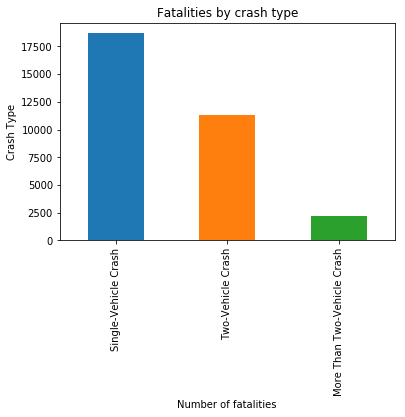

In [6]:
#Plot fatalities by crash type
acc_aux_df['crash_type'].value_counts().plot(kind='bar')
plt.title('Fatalities by crash type')
plt.ylabel("Crash Type")
plt.xlabel("Number of fatalities")
plt.savefig('Fatalities_by_crash_type.png')
plt.show()

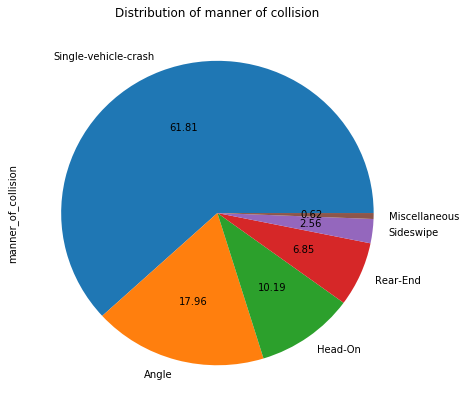

In [7]:
#Plot pie chart for manner of collision
acc_aux_df['manner_of_collision'].value_counts().plot(kind='pie',figsize=(7,7),autopct='%.2f',legend=False)
plt.title('Distribution of manner of collision')
plt.savefig('Distribution_of_manner_of_collision.png')
plt.show()

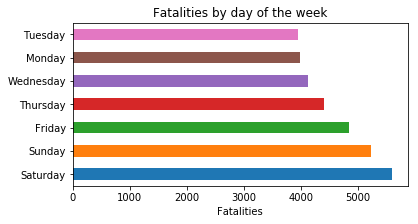

In [8]:
#Plot fatalities by day of week
acc_aux_df['day_of_week_name'].value_counts().plot(kind='barh',figsize=(6,3))
plt.title('Fatalities by day of the week')
plt.xlabel('Fatalities')
plt.savefig('Fatalities_by_day_of_week.png')
plt.show()

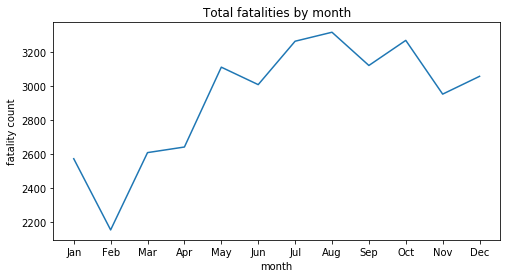

In [9]:
#Plot a graph of total number of fatalities by months
acc_aux_df.groupby('month')['fatalities'].sum().plot(subplots=False,figsize=(8,4))
plt.title('Total fatalities by month')
plt.xticks((1,2,3,4,5,6,7,8,9,10,11,12), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.ylabel('fatality count')
plt.savefig('Total_fatalities_by_month.png')
plt.show()

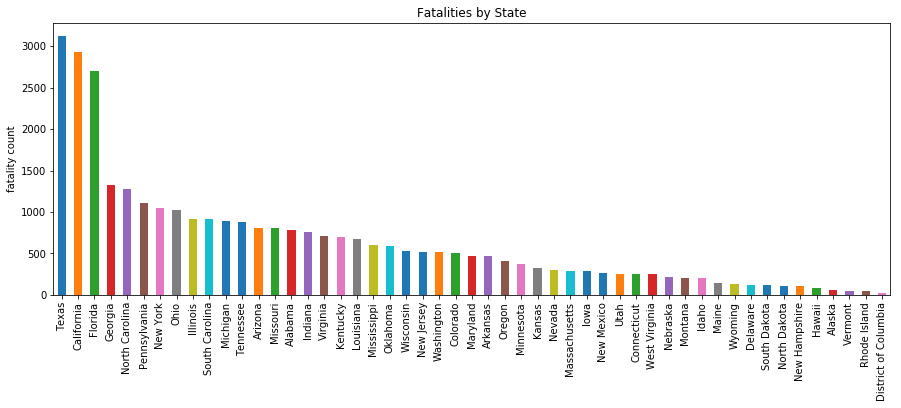

In [10]:
#Plot fatalities by state
acc_aux_df['state'].value_counts().plot(kind='bar',figsize=(15,5))
plt.title('Fatalities by State')
plt.ylabel('fatality count')
plt.savefig('Fatalities_by_State.png')
plt.show()

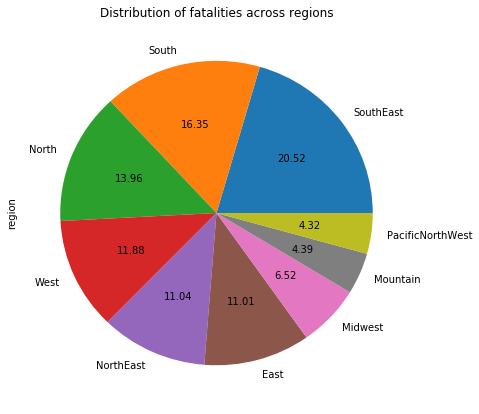

In [11]:
#Plot pie chart of fatalities by region
acc_aux_df['region'].value_counts().plot(kind='pie',figsize=(7,7),autopct='%.2f',legend=False)
plt.title('Distribution of fatalities across regions')
plt.savefig('Distribution_of_fatalities_across_regions.png')
plt.show()

<Figure size 432x288 with 0 Axes>

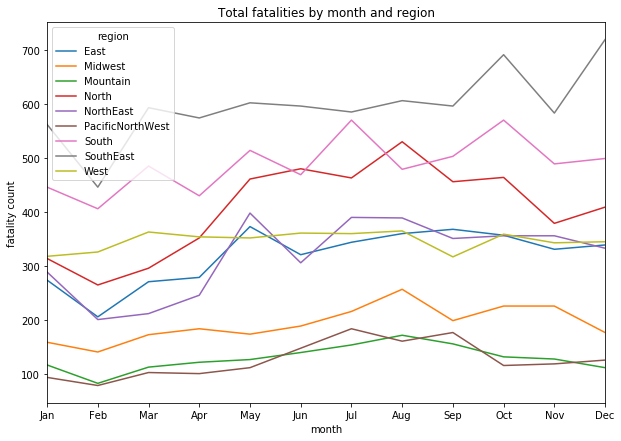

In [12]:
#Plot a graph of total number of fatalities by region and month 
plt.figure()
acc_aux_df.groupby(['month','region'])['fatalities'].sum().unstack().plot(subplots=False,figsize=(10,7),
                                                                                xlim=(1,12))
plt.title('Total fatalities by month and region')
plt.ylabel('fatality count')
plt.xticks((1,2,3,4,5,6,7,8,9,10,11,12), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.savefig('Total_fatalities_by_month_and_region.png')
plt.show()

In [13]:
#Cleaning records with null lat or long 
acc_aux_df_cleaned=acc_aux_df.dropna(subset=['lat','long'])

In [14]:
# Plot Heatmap of fatalities across the country
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(acc_aux_df_cleaned[["lat", "long"]], weights=acc_aux_df_cleaned["fatalities"], 
                                 dissipating=False, max_intensity=300,
                                 point_radius=1)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [15]:
#Find top 25 cities with highest no. of fatalities 
top25_cities=acc_aux_df_cleaned.groupby(['closest_city','state','lat','long'])['ST_CASE'].count().reset_index(name='count').sort_values(['count'],
                                                                                                                                        ascending=False).head(25)

In [16]:
fig = gmaps.figure()
markers = gmaps.marker_layer(top25_cities[['lat','long']])
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

In [17]:
top25_cities

,closest_city,state,lat,long,count
457,hacienda heights,California,34.0,-118.0,656
56,aventura,Florida,26.0,-80.0,529
620,lewisville,Texas,33.0,-97.0,458
609,lawrenceville,Georgia,34.0,-84.0,384
1125,westwood,New York,41.0,-74.0,363
311,elk grove village,Illinois,42.0,-88.0,353
49,atascocita,Texas,30.0,-95.0,321
1150,winston,Florida,28.0,-82.0,302
595,langley park,Maryland,39.0,-77.0,280
1160,yucaipa,California,34.0,-117.0,270
